# Assingment 2: Explainable AI and Hyperparameter Optimization

Samih Amer

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd, re
import re
from collections import defaultdict
from numpy.linalg import norm
from scipy.spatial.distance import cosine 
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gzip, io
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

In [2]:
df_movies = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_movie.csv')
df_ratings = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_rating.csv')

tags = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_genome_tags.csv')
scores =  pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_genome_scores.csv')

genres_df = df_movies[['movieId', 'genres']].copy()

## Problem 1 - Rework the movielens dataset to determine a set of 19 tags that explains one of the 19 Genres while having an inert relation with the rest of the genres

In [3]:
GENRES = ['Action','Adventure','Animation',"Children",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical',
          'Mystery','Romance','Sci-Fi','Thriller','War','Western','IMAX']

genres_df['genres'] = genres_df['genres'].fillna('')          
genres_df = genres_df[genres_df['genres'].str.contains('|'.join(GENRES))]

Explode genre list -> one row per (movie, genre)

In [4]:
gexpl = (genres_df.assign(genres=genres_df['genres'].str.split('|'))
                    .explode('genres')
                    .query("genres in @GENRES"))

Merge relevance scores with exploded genres

In [5]:
merge = gexpl[['movieId','genres']].merge(scores, on='movieId', how='inner')
merge = merge.merge(tags, on='tagId', how='left')

Sum relevance per (genre, tag)

In [6]:
grp = merge.groupby(['genres','tag']).agg(rel_sum=('relevance','sum'))

Probability P(tag|genre) ~ relevance_sum / total_relevance_in_genre

In [7]:
tot = grp.groupby(level=0)['rel_sum'].transform('sum')
p_tag_genre = grp['rel_sum'] / tot

In [8]:
p_tag_all   = (merge.groupby('tag')['relevance'].sum() /
               merge['relevance'].sum())
p_tag_other = lambda g: ( (merge[merge['genres']!=g]
                           .groupby('tag')['relevance']
                           .sum()) /
                         merge[merge['genres']!=g]['relevance'].sum() )

Pick best tag per genre

In [9]:
best_tags = {}
norm = lambda s: re.sub(r'[^a-z]', '', s.lower())   # letters only

for g in GENRES:
    s = p_tag_genre.xs(g) - p_tag_other(g)          # score
    g_norm = norm(g)

    for tag in s.sort_values(ascending=False).index:
        if g_norm not in norm(tag):                 # strict check for not using the genre name as a tag
            best_tags[g] = tag
            break

In [10]:
best = pd.Series(best_tags).rename_axis('Genre').to_frame('Representative tag')
display(best)

,Representative tag
Genre,
Action,fight scenes
Adventure,action
Animation,animated
Children,kids
Comedy,funny
Crime,murder
Documentary,politics
Drama,intimate
Fantasy,magic


## Problem 2: Build a model for the MNIST dataset. Use LIME image explainer to find our how digits are predicted. Plot one good explanation figure for every figure 0 to 9 

In [11]:
from pathlib import Path
import gzip, struct
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda
from lime.lime_image import LimeImageExplainer
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
DATA_DIR = '/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/MNIST/raw'
EPOCHS = 13
BATCH = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
def read_idx(fname: Path) -> np.ndarray:
    with open(fname, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic == 0x00000803:  # images
            rows, cols = struct.unpack(">II", f.read(8))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        elif magic == 0x00000801:  # labels
            return np.frombuffer(f.read(), dtype=np.uint8)
        else:
            raise ValueError("Unknown IDX file")

In [14]:
class MNISTRGB(Dataset):
    def __init__(self, imgs, labels, train=True):
        self.X = imgs.astype(np.float32) / 255.0
        self.y = labels.astype(np.int64)
        self.train = train
        self.tt = ToTensor()
    def __len__(self):  return len(self.y)
    def __getitem__(self, idx):
        img = self.X[idx]
        rgb = gray2rgb(img)               # (28,28,3)
        if self.train:
            x = torch.tensor(rgb).permute(2,0,1)    # (3,28,28)
            return x, self.y[idx]
        else:
            return rgb, self.y[idx]       # np array for LIME 

#### Load dataset

In [15]:
train_imgs = read_idx(Path(DATA_DIR) / "train-images-idx3-ubyte")
train_lbls = read_idx(Path(DATA_DIR) / "train-labels-idx1-ubyte")
test_imgs  = read_idx(Path(DATA_DIR) / "t10k-images-idx3-ubyte")
test_lbls  = read_idx(Path(DATA_DIR) / "t10k-labels-idx1-ubyte")

In [16]:
ds_full = MNISTRGB(train_imgs, train_lbls)
ds_test = MNISTRGB(test_imgs, test_lbls, train=False)

len_val = 5000
ds_train, ds_val = random_split(ds_full, [len_val, len(ds_full) - len_val])

dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=BATCH, shuffle=False)
dl_test = DataLoader([(gray2rgb(img), lbl) for img,lbl in zip(test_imgs,test_lbls)],  
                      batch_size=1, shuffle=False)


Lightweight CNN

In [17]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1),nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7,128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128,10)
        )
    def forward(self,x): return self.net(x)

model = SimpleNet().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), 1e-3)
lossF = nn.CrossEntropyLoss()

Training Loop

In [18]:
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in tqdm(dl_train, desc=f"Epoch {epoch+1}/EPOCHS"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = lossF(pred, yb)
        loss.backward(); opt.step()
    
    model.eval(); correct = total = 0 
    with torch.no_grad():
        for xb, yb in dl_val:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            correct += (model(xb).argmax(1) == yb).sum().item()
            total += yb.size(0)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Acc: {correct/total:.4f}")
    

Epoch 1/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.02it/s]


Epoch 1, Loss: 0.3926, Val Acc: 0.8536


Epoch 2/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.49it/s]


Epoch 2, Loss: 0.1806, Val Acc: 0.9111


Epoch 3/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 17.71it/s]


Epoch 3, Loss: 0.1066, Val Acc: 0.9350


Epoch 4/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.94it/s]


Epoch 4, Loss: 0.0560, Val Acc: 0.9509


Epoch 5/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.80it/s]


Epoch 5, Loss: 0.0115, Val Acc: 0.9548


Epoch 6/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.31it/s]


Epoch 6, Loss: 0.1213, Val Acc: 0.9612


Epoch 7/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.18it/s]


Epoch 7, Loss: 0.0863, Val Acc: 0.9607


Epoch 8/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.28it/s]


Epoch 8, Loss: 0.0248, Val Acc: 0.9644


Epoch 9/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.23it/s]


Epoch 9, Loss: 0.0147, Val Acc: 0.9667


Epoch 10/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.41it/s]


Epoch 10, Loss: 0.0132, Val Acc: 0.9686


Epoch 11/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.85it/s]


Epoch 11, Loss: 0.0307, Val Acc: 0.9680


Epoch 12/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 18.95it/s]


Epoch 12, Loss: 0.0002, Val Acc: 0.9690


Epoch 13/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.53it/s]


Epoch 13, Loss: 0.0001, Val Acc: 0.9680


#### Generate one good explanation per digit

In [19]:
explainer = LimeImageExplainer()
examples  = {}
model.eval()

for img_t, label in dl_test:          # img_t: (1, 28, 28, 3)  uint8
    img_t  = img_t.squeeze(0)         # (28, 28, 3) uint8
    img_np = img_t.cpu().numpy()      

    # prediction path 
    input_tensor = (img_t.float() / 255.)      
    input_tensor = input_tensor.permute(2,0,1) 
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

    pred = model(input_tensor).argmax(1).item()
    true = label.item() if torch.is_tensor(label) else label

    if pred == true and pred not in examples:
        examples[pred] = img_np          
    if len(examples) == 10:
        break

In [20]:
def batch_predict(images_np):
    imgs = torch.tensor(images_np.transpose((0,3,1,2))).float()
    imgs = imgs.div(255.).to(DEVICE)     
    with torch.no_grad():
        logits = model(imgs)
    return torch.softmax(logits, dim=1).cpu().numpy()

#### Plot explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

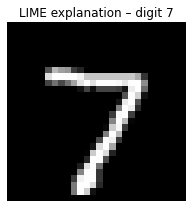

  0%|          | 0/1000 [00:00<?, ?it/s]

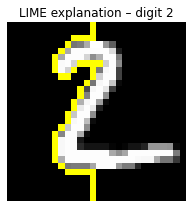

  0%|          | 0/1000 [00:00<?, ?it/s]

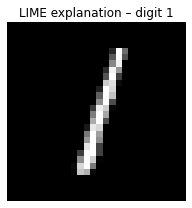

  0%|          | 0/1000 [00:00<?, ?it/s]

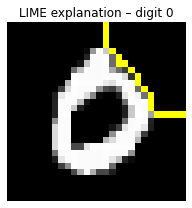

  0%|          | 0/1000 [00:00<?, ?it/s]

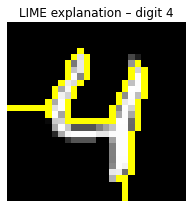

  0%|          | 0/1000 [00:00<?, ?it/s]

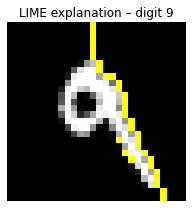

  0%|          | 0/1000 [00:00<?, ?it/s]

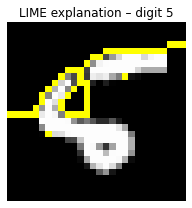

  0%|          | 0/1000 [00:00<?, ?it/s]

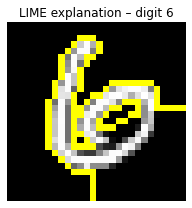

  0%|          | 0/1000 [00:00<?, ?it/s]

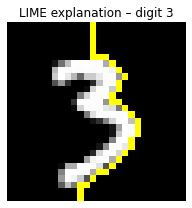

  0%|          | 0/1000 [00:00<?, ?it/s]

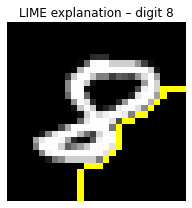


Saved figures ➜ /Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/lime_figs


In [21]:
OUT_DIR = Path("lime_figs"); OUT_DIR.mkdir(exist_ok=True)
for digit, img_np in examples.items():
    exp = explainer.explain_instance(img_np,
                                     classifier_fn=batch_predict,
                                     top_labels=1,
                                     hide_color=0,
                                     num_samples=1000)
   
    # Explanation mask for digit
    temp, mask = exp.get_image_and_mask(digit,
                                        positive_only=True,
                                        num_features=10,
                                        hide_rest=False)
    
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(mark_boundaries(temp.astype(np.uint8), mask))
    ax.set_title(f"LIME explanation – digit {digit}")
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(OUT_DIR/f"digit_{digit}.png", dpi=150)
    plt.show()
print(f"\nSaved figures ➜ {OUT_DIR.resolve()}")

### Discussion of Results

In theory, the table below shows us what we SHOULD expect based from an explainer such as LIME

| **Digit** | **Most salient (bright-green) regions highlighted by LIME** | **Intuition / discriminative cues** |
|-----------|-----------------------------------------------------------|-------------------------------------|
| **0** | Complete circular outline, often both left and right arcs | Presence of a **closed loop** distinguishes 0 from 6, 8, 9 |
| **1** | Central vertical stroke; sometimes small serif at top | A lonely straight column; easy to separate from 7 or 4 |
| **2** | Upper horizontal curve and bottom-right diagonal tail | The *top arch → diagonal sweep* combo is unique to 2 |
| **3** | Upper & lower loops, little focus on mid-spine | Two stacked semi-circles identify 3 vs 8 |
| **4** | Left vertical and crossing horizontal/diagonal forming the open box | The open top and hard angles matter; no loop anywhere |
| **5** | Top horizontal bar plus bottom-left curve | High importance on *sharp edge ↘ curve* transition |
| **6** | Loop at bottom plus small inward hook upper-right | Closed lower loop + open top distinguishes from 0 and 8 |
| **7** | Long top bar and descending diagonal stroke | No vertical line at left (unlike 4); the slanted leg stands out |
| **8** | Both stacked loops with waist pinch | Two full loops; saliency appears on **both** circles |
| **9** | Upper loop and descending vertical tail | Mirror of 6: emphasis on upper loop + lower straight |

---

### Patterns actually observed

For digits 1 and 7, we see that the mask is empty. This isn't caused by a bug in our code, but it's actually a side effect of the way we asked LIME to build the explanation. In our parameters for the LIME explainer, we set "Positive_only = True", LIME is ranking the super pixels by the weight it assigns them in the local surrogate model, if all the top-10 classes have negative weight, or their positive weight is very close to zero, the call `exp.get_image_and_mask` discards them which means the mask is all-zeros and gives us no yellow contour. This happens for digits where the network relies on the absence of certain strokes, like a loop rather than the presence of a distinctive one. 

For the digit `1`, the model decides it's a 1 based on the absence of a horizontal bar, loop, and left stroke, so the negative evidence dominates. 

For the digit `7`, the diagonal bar is already present in many 2's and some 9's, so the positive weight of that super pixel can be small; meanwhile the absence of a left vertical stroke (that would turn it into a 4) receives negative weight. 

In different testing of my network with some parameter optimization, 5 would also sometimes return an empty mask. This is because the positive may be weak due to "Not-a-loop" to avoid 6/9 and the gap on the right may be encoded as negative weights. 

This could also be a quirk of the super-pixel segmentation. The default Quickshift parameters `(kernel_size=4, max_dist=200, ratio=0.2)` can place all pixels of a thin digit into a single super-pixel. If that super-pixel lies flush with the image edge, mark_boundaries also draws nothing because there is no interior boundary.

So therefore, seeing an empty mask is informative: it tells us that for those digits, the model's decision is driven more by the "Lack of something" (negative evidence) than by a clearly present stroke. 